with https://www.kaggle.com/sarques/aiwitbor  and https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Flatten
from keras import backend as K
import itertools
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import categorical_accuracy

Using TensorFlow backend.


In [3]:
base_add = os.path.join('data')
print(base_add)
print(os.listdir(base_add))

data
['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'images', 'resized_images']


# Preprocess imtems like in previous file

In [4]:
images_paths = list(Path(base_add).glob(os.path.join('resized_images', '*.jpg')))

In [5]:
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in images_paths}
print(list(image_path_dict.keys())[0])
print(list(image_path_dict.values())[0])
lesion_type_dict = {'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}
df = pd.read_csv(os.path.join(base_add, 'HAM10000_metadata.csv'))

ISIC_0024306
data\resized_images\ISIC_0024306.jpg


In [6]:
df[df['dx'] == 'mel'].head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity
1214,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest


In [7]:
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['path'] = df['image_id'].map(image_path_dict.get)
df['dx_code'] = pd.Categorical(df['dx']).codes
df['age'].fillna(df['age'].mean(), inplace = True)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,dx_code,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,data\resized_images\ISIC_0027419.jpg,2,"[[[186, 153, 198], [184, 151, 196], [188, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,data\resized_images\ISIC_0025030.jpg,2,"[[[25, 16, 33], [22, 11, 28], [24, 11, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,data\resized_images\ISIC_0026769.jpg,2,"[[[176, 131, 138], [185, 140, 147], [190, 144,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,data\resized_images\ISIC_0025661.jpg,2,"[[[27, 7, 9], [38, 16, 19], [49, 26, 32], [58,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,data\resized_images\ISIC_0031633.jpg,2,"[[[142, 92, 117], [153, 103, 128], [167, 117, ..."


In [9]:
feats = df.drop(['dx_code'], axis = 1)
target = df['dx_code']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)

In [11]:

x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())
x_valid = np.asarray(x_valid['image'].tolist())



In [12]:
example_image = x_train[0]
example_image.shape

(75, 100, 3)

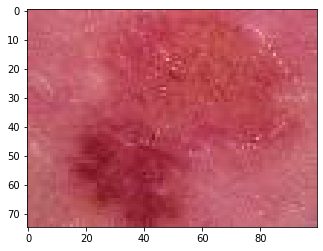

In [13]:
imgplot = plt.imshow(example_image)

In [14]:
# Normalization
x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)
x_valid_mean = np.mean(x_valid)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)
x_valid_std = np.std(x_valid)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
x_valid = (x_valid - x_valid_mean)/x_valid_std

In [15]:
# Label Encodeing
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_valid = to_categorical(y_valid, num_classes = 7)

In [16]:
x_train = x_train.reshape(x_train.shape[0],75, 100, 3)
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_valid = x_valid.reshape(x_valid.shape[0], *(75, 100, 3))

In [17]:
input_shape = (75, 100, 3)
num_classes = 7

In [18]:
example_image = x_train[5012]
example_image.shape

(75, 100, 3)

W0904 13:32:19.305326 17072 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


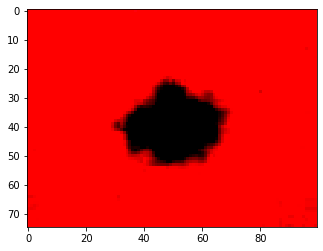

In [19]:
imgplot = plt.imshow(example_image)

# Get the pretrained ConvNet

In [20]:
base_model = keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0904 13:32:19.513769 17072 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 13:32:19.538703 17072 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 13:32:19.544688 17072 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform i

In [21]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 77, 101, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 38, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 38, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
x = base_model.layers[-1].output
print(x)
print(base_model.input)

Tensor("out_relu/Relu6:0", shape=(?, 3, 4, 1280), dtype=float32)
Tensor("input_1:0", shape=(?, 75, 100, 3), dtype=float32)


In [23]:

x = Dropout(0.25)(x)
flattened = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(flattened)

# Create a new model with the new outputs
model = Model(inputs=base_model.input, outputs=predictions)

W0904 13:32:26.462184 17072 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [25]:
optimizer = Adam(lr = .001, beta_1 = .9, beta_2 = .999, epsilon = None, decay = .0, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = [categorical_accuracy])

W0904 13:32:26.603807 17072 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 77, 101, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 38, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 38, 50, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [27]:
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False,
                            featurewise_std_normalization = False, samplewise_std_normalization = False, 
                            zca_whitening = False, rotation_range = 10, zoom_range = 0.1, 
                            width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, 
                            vertical_flip = True)
datagen.fit(x_train)

In [28]:
datagen.flow(x_train, y_train, batch_size = 1)[0][1]

array([[0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [29]:
class_weights={
    0: 1.0,  
    1: 1.0,  
    2: 1.0,  
    3: 1.0,  
    4: 1.0,  # mel
    5: 1.0,  
    6: 1.0,  
}

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy', patience = 3, verbose = 1, 
                                           factor = 0.2, min_lr = 0.0001)

In [31]:
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [32]:
epochs = 2
batch_size = 10
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), 
                             epochs = epochs,
                              verbose = 1,
                              class_weight=class_weights,
                              validation_data=datagen.flow(x_valid, y_valid, batch_size = batch_size),                              
                              callbacks=[checkpoint, learning_rate_reduction]
                             )



W0904 13:32:28.437901 17072 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
641/641 [==============================] - 229s 357ms/step - loss: 3.0716 - categorical_accuracy: 0.6163 - val_loss: 5.3885 - val_categorical_accuracy: 0.6625

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66251, saving model to best_model.h5
Epoch 2/2
641/641 [==============================] - 236s 368ms/step - loss: 3.3558 - categorical_accuracy: 0.6490 - val_loss: 5.1015 - val_categorical_accuracy: 0.6656

Epoch 00002: val_categorical_accuracy improved from 0.66251 to 0.66563, saving model to best_model.h5


In [33]:
test_batches = datagen.flow(x_test, y_test, batch_size = batch_size)

In [36]:
test_loss, val_acc  = model.evaluate_generator(test_batches)
print(test_loss)
print(val_acc)

4.822895903750955
0.6809785349542834


In [ ]:
#model.load_weights('best_model.h5')